In [ ]:
# importing libraries and packages
import tensorflow as tf

print(tf.__version__)

2.4.1


In [ ]:
# installing kaggle to download the dataset using kaggle API
!pip install -q kaggle

In [ ]:
# uploading kaggle API
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sathushkajayasuriya","key":"7a15792d8105fde3d9096ef4c019d2d0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# downloading the dataset, link : https://www.kaggle.com/grassknoted/asl-alphabet
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:30<00:00, 38.5MB/s]
100% 1.03G/1.03G [00:30<00:00, 36.3MB/s]


In [ ]:
# unzipping the downloaded dataset 
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
# Specifying the training and test directories

TRAINING_DIR = './asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './asl_alphabet_test/asl_alphabet_test/'

In [ ]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [ ]:
# downloading custom weight file
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-20 16:14:15--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M  74.8MB/s    in 1.1s    

2021-04-20 16:14:16 (74.8 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

# Enabling the top 2 inception blocks to train
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
    
# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 99, 99, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
# Adding our own set of fully connected layers at the end of Inception v3 weight file
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(29, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
#printing new model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 99, 99, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 99, 99, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:
# Creating a callback to stop model training after reaching a required accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [ ]:
# training new model

history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
100/100 [==============================] - 139s 1s/step - loss: 3.4448 - acc: 0.0373 - val_loss: 3.3777 - val_acc: 0.0478
Epoch 2/50
100/100 [==============================] - 102s 1s/step - loss: 3.2052 - acc: 0.1350 - val_loss: 3.1221 - val_acc: 0.1675
Epoch 3/50
100/100 [==============================] - 102s 1s/step - loss: 2.9731 - acc: 0.2842 - val_loss: 2.9240 - val_acc: 0.2769
Epoch 4/50
100/100 [==============================] - 102s 1s/step - loss: 2.7204 - acc: 0.4261 - val_loss: 2.7280 - val_acc: 0.3800
Epoch 5/50
100/100 [==============================] - 102s 1s/step - loss: 2.4287 - acc: 0.5412 - val_loss: 2.4594 - val_acc: 0.4925
Epoch 6/50
100/100 [==============================] - 102s 1s/step - loss: 2.1115 - acc: 0.6486 - val_loss: 2.1717 - val_acc: 0.5863
Epoch 7/50
100/100 [==============================] - 102s 1s/step - loss: 1.7947 - acc: 0.7391 - val_loss: 1.8779 - val_acc: 0.6619
Epoch 8/50
100/100 [==============================] - 101s 1s/step - 

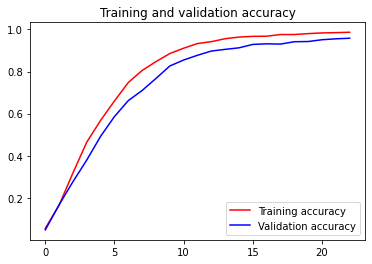

<Figure size 432x288 with 0 Axes>

In [ ]:
# Training Accuracy vs Validation Accuracy graph

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

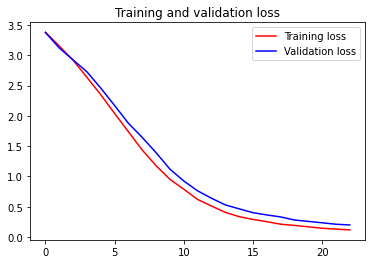

<Figure size 432x288 with 0 Axes>

In [ ]:
# Training Loss vs Validation Loss

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
# Saving the model
from google.colab import files

MODEL_NAME = 'models/asl_alphabet_codeX.h5'
model.save(MODEL_NAME)
files.download('asl_alphabet_codeX.h5')

Actual class: V 
 Predicted class: V


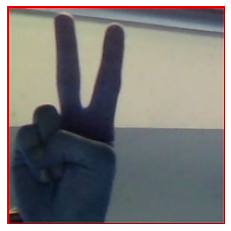

Actual class: E 
 Predicted class: E


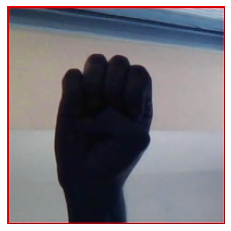

Actual class: L 
 Predicted class: L


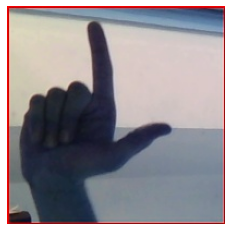

Actual class: P 
 Predicted class: P


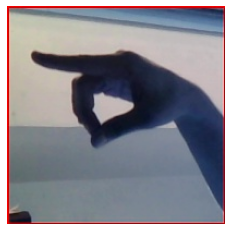

Actual class: H 
 Predicted class: H


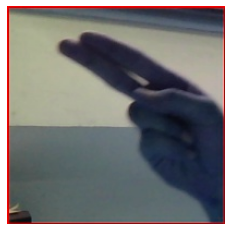

Actual class: I 
 Predicted class: I


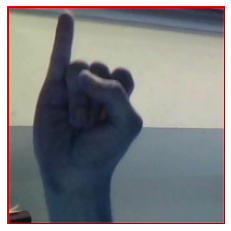

Actual class: K 
 Predicted class: K


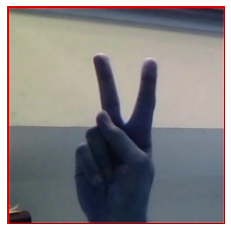

Actual class: J 
 Predicted class: J


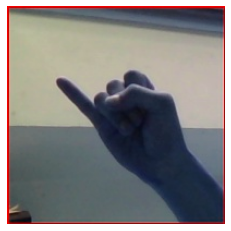

Actual class: C 
 Predicted class: C


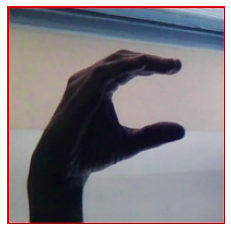

Actual class: Y 
 Predicted class: J


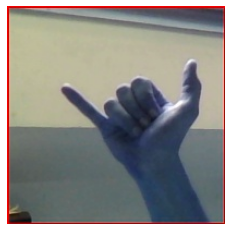

Actual class: X 
 Predicted class: X


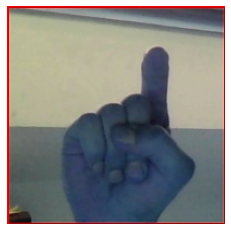

Actual class: space 
 Predicted class: space


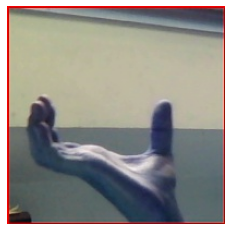

Actual class: T 
 Predicted class: T


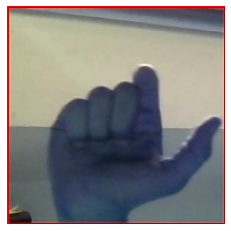

Actual class: W 
 Predicted class: W


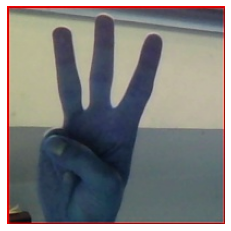

Actual class: Q 
 Predicted class: Q


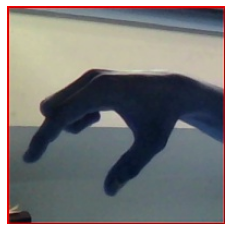

Actual class: R 
 Predicted class: R


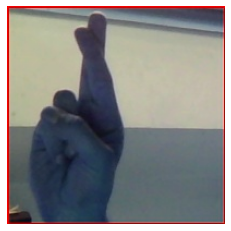

Actual class: D 
 Predicted class: D


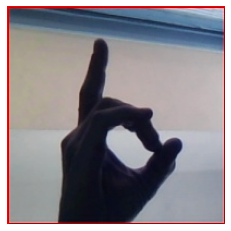

Actual class: G 
 Predicted class: G


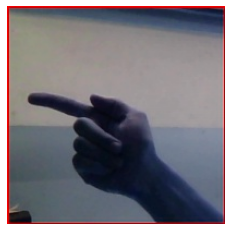

Actual class: A 
 Predicted class: A


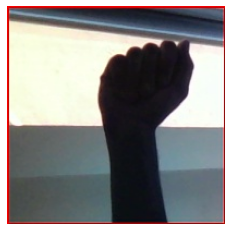

Actual class: U 
 Predicted class: U


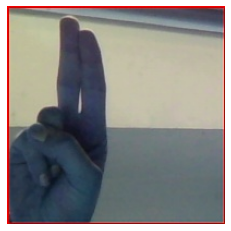

Actual class: N 
 Predicted class: N


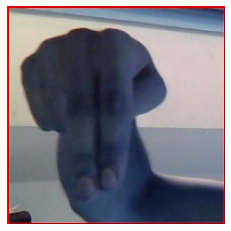

Actual class: S 
 Predicted class: S


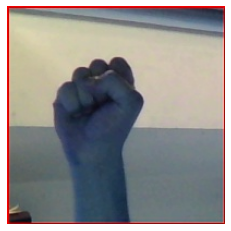

Actual class: M 
 Predicted class: M


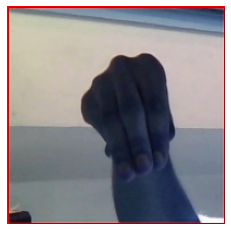

Actual class: Z 
 Predicted class: Z


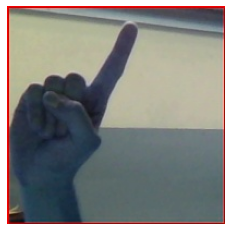

Actual class: O 
 Predicted class: O


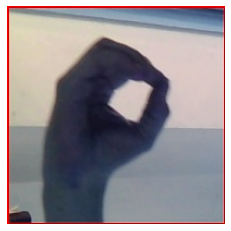

Actual class: B 
 Predicted class: B


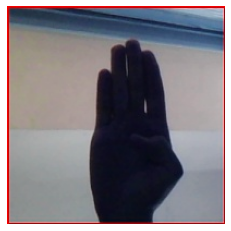

Actual class: F 
 Predicted class: F


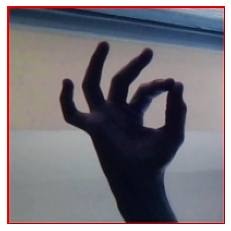

Actual class: nothing 
 Predicted class: nothing


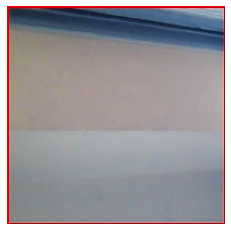

In [ ]:
# testing trained model 

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

classes = os.listdir(TRAINING_DIR)
classes.sort()

for i, test_image in enumerate(os.listdir(TEST_DIR)):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

In [ ]:
# calculating test accuracy 

test_images = os.listdir(TEST_DIR)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)

Actual class: V - Predicted class: V PASS!
Actual class: E - Predicted class: E PASS!
Actual class: L - Predicted class: L PASS!
Actual class: P - Predicted class: P PASS!
Actual class: H - Predicted class: H PASS!
Actual class: I - Predicted class: I PASS!
Actual class: K - Predicted class: K PASS!
Actual class: J - Predicted class: J PASS!
Actual class: C - Predicted class: C PASS!
Actual class: Y - Predicted class: J FAIL!
Actual class: X - Predicted class: X PASS!
Actual class: space - Predicted class: space PASS!
Actual class: T - Predicted class: T PASS!
Actual class: W - Predicted class: W PASS!
Actual class: Q - Predicted class: Q PASS!
Actual class: R - Predicted class: R PASS!
Actual class: D - Predicted class: D PASS!
Actual class: G - Predicted class: G PASS!
Actual class: A - Predicted class: A PASS!
Actual class: U - Predicted class: U PASS!
Actual class: N - Predicted class: N PASS!
Actual class: S - Predicted class: S PASS!
Actual class: M - Predicted class: M PASS!
Act

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 432x288 with 0 Axes>

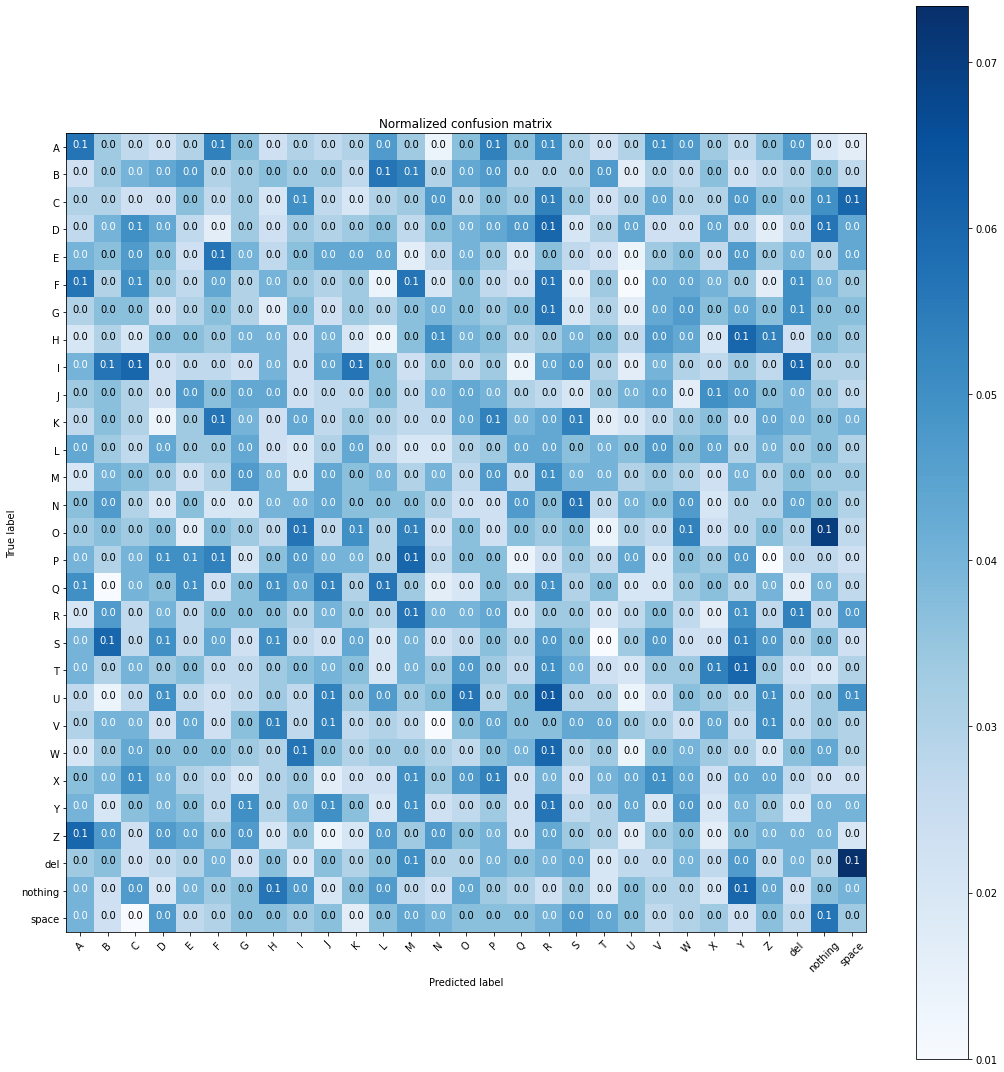

In [ ]:
# show the confusion matrix of our predictions

predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()